# Compression of DL models

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


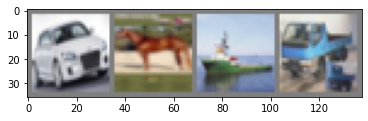

car   horse ship  truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
net = net.to(device)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.199 [1,  4000] loss: 1.841 [1,  6000] loss: 1.641 [1,  8000] loss: 1.572 [1, 10000] loss: 1.510 [1, 12000] loss: 1.461 [2,  2000] loss: 1.376 [2,  4000] loss: 1.343 [2,  6000] loss: 1.308 [2,  8000] loss: 1.321 [2, 10000] loss: 1.288 [2, 12000] loss: 1.240 [3,  2000] loss: 1.201 [3,  4000] loss: 1.175 [3,  6000] loss: 1.157 [3,  8000] loss: 1.158 [3, 10000] loss: 1.167 [3, 12000] loss: 1.125 [4,  2000] loss: 1.064 [4,  4000] loss: 1.073 [4,  6000] loss: 1.070 [4,  8000] loss: 1.066 [4, 10000] loss: 1.043 [4, 12000] loss: 1.065 [5,  2000] loss: 0.994 [5,  4000] loss: 0.975 [5,  6000] loss: 0.978 [5,  8000] loss: 1.023 [5, 10000] loss: 1.000 [5, 12000] loss: 1.021 [6,  2000] loss: 0.913 [6,  4000] loss: 0.927 [6,  6000] loss: 0.948 [6,  8000] loss: 0.935 [6, 10000] loss: 0.952 [6, 12000] loss: 0.951 [7,  2000] loss: 0.860 [7,  4000] loss: 0.876 [7,  6000] loss: 0.899 [7,  8000] loss: 0.906 [7, 10000] loss: 0.906 [7, 12000] loss: 0.917 [8,  2000] loss: 0.811 [8,  4000] 

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


In [29]:
im = images[0,:,:,:].reshape(1,3,32,32).to(device)

In [34]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = net(im)

413 µs ± 56.7 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Pruning

In [35]:
import torch.nn.utils.prune as prune

In [41]:
net = Net()
net = net.to(device)

parameters_to_prune = (
    (net.conv1, 'weight'),
    (net.conv2, 'weight'),
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.266 [1,  4000] loss: 1.967 [1,  6000] loss: 1.746 [1,  8000] loss: 1.602 [1, 10000] loss: 1.525 [1, 12000] loss: 1.482 [2,  2000] loss: 1.429 [2,  4000] loss: 1.400 [2,  6000] loss: 1.365 [2,  8000] loss: 1.339 [2, 10000] loss: 1.316 [2, 12000] loss: 1.291 [3,  2000] loss: 1.254 [3,  4000] loss: 1.231 [3,  6000] loss: 1.218 [3,  8000] loss: 1.217 [3, 10000] loss: 1.195 [3, 12000] loss: 1.194 [4,  2000] loss: 1.114 [4,  4000] loss: 1.138 [4,  6000] loss: 1.142 [4,  8000] loss: 1.135 [4, 10000] loss: 1.133 [4, 12000] loss: 1.103 [5,  2000] loss: 1.047 [5,  4000] loss: 1.049 [5,  6000] loss: 1.054 [5,  8000] loss: 1.061 [5, 10000] loss: 1.079 [5, 12000] loss: 1.076 [6,  2000] loss: 0.973 [6,  4000] loss: 1.011 [6,  6000] loss: 1.017 [6,  8000] loss: 0.995 [6, 10000] loss: 1.008 [6, 12000] loss: 1.012 [7,  2000] loss: 0.920 [7,  4000] loss: 0.935 [7,  6000] loss: 0.963 [7,  8000] loss: 0.966 [7, 10000] loss: 0.987 [7, 12000] loss: 0.959 [8,  2000] loss: 0.894 [8,  4000] 

In [42]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [48]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = net(im)

1.06 ms ± 491 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Quantization 

In [49]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.150 [1,  4000] loss: 1.798 [1,  6000] loss: 1.643 [1,  8000] loss: 1.554 [1, 10000] loss: 1.516 [1, 12000] loss: 1.444 [2,  2000] loss: 1.375 [2,  4000] loss: 1.346 [2,  6000] loss: 1.332 [2,  8000] loss: 1.313 [2, 10000] loss: 1.257 [2, 12000] loss: 1.260 [3,  2000] loss: 1.205 [3,  4000] loss: 1.190 [3,  6000] loss: 1.168 [3,  8000] loss: 1.177 [3, 10000] loss: 1.160 [3, 12000] loss: 1.163 [4,  2000] loss: 1.085 [4,  4000] loss: 1.105 [4,  6000] loss: 1.092 [4,  8000] loss: 1.072 [4, 10000] loss: 1.070 [4, 12000] loss: 1.067 [5,  2000] loss: 0.998 [5,  4000] loss: 1.013 [5,  6000] loss: 1.009 [5,  8000] loss: 1.040 [5, 10000] loss: 1.018 [5, 12000] loss: 1.011 [6,  2000] loss: 0.941 [6,  4000] loss: 0.942 [6,  6000] loss: 0.940 [6,  8000] loss: 0.961 [6, 10000] loss: 0.969 [6, 12000] loss: 0.993 [7,  2000] loss: 0.872 [7,  4000] loss: 0.893 [7,  6000] loss: 0.910 [7,  8000] loss: 0.939 [7, 10000] loss: 0.937 [7, 12000] loss: 0.952 [8,  2000] loss: 0.833 [8,  4000] 

In [56]:
# insert observers
torch.quantization.prepare(net, inplace=True)

# Calibrate the model and collect statistics

# convert to quantized version
torch.quantization.convert(net, inplace=True)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [57]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


In [58]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = net(im)

390 µs ± 43.4 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [59]:
Net()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)